### Stylometric analysis of adult vs. children's literature (improved)

#### Importing modules and packages

In [1]:
import os
import codecs
import pprint as pp

import pandas as pd

import numpy as np

# for interactive selection of parameters, variables, etc. (https://ipywidgets.readthedocs.io/)
from ipywidgets import interactive, interact
import ipywidgets as widgets
from IPython.display import display

# lightweight pretty printing console (https://pypi.org/project/wasabi/)
from wasabi import msg, wrap

#### Creating dictionary to store meta-data

In [3]:
# open and extract info from xlsx
#df = pd.read_excel('meta.xlsx')

#meta_dict = {df.loc[idx, 'file']: [df.loc[idx, 'title'], df.loc[idx, 'author'], df.loc[idx, 'age'], df.loc[idx, 'period'], df.loc[idx, 'reader']] for idx in range(df.shape[0])}
#print('Total number of titles:', len(meta_dict))
#pp.pprint(meta_dict)

In [4]:
lang_author_widget = widgets.SelectMultiple(
    options=['English', 'Dutch'],
    value=['Dutch'],
    description='Language',
    disabled=False
)
msg.divider("Which language do you want to analyze?")
display(lang_author_widget)


=================== Which language do you want to analyze? ===================


SelectMultiple(description='Language', index=(1,), options=('English', 'Dutch'), value=('Dutch',))

In [24]:
msg.divider("Which authors do you want to include in the analysis?")
lang_author = [i for i in lang_author_widget.value]

if lang_author[0] == 'Dutch':
    author_sub_corpus_widget = widgets.SelectMultiple(
        options=['Franck', 'Kuijer', 'Moeyaert', 'Vandermeeren', 'Van Leeuwen'],
        value=['Franck', 'Kuijer', 'Moeyaert', 'Vandermeeren', 'Van Leeuwen'], # default: all Dutch author
        description='Authors:',
        disabled=False)
    
    display(author_sub_corpus_widget)
    
elif lang_author[0] == 'English':
    author_sub_corpus_widget = widgets.SelectMultiple(
        options=['Almond', 'Chambers', 'Fine', 'Gaiman', 'Pullman', 'Rowling'],
        value=['Almond', 'Chambers', 'Fine', 'Gaiman', 'Pullman', 'Rowling'], # default: all English author
        description='Authors:',
        disabled=False)
    
    display(author_sub_corpus_widget)


=========== Which authors do you want to include in the analysis? ===========


SelectMultiple(description='Authors:', index=(0, 1, 2, 3, 4), options=('Franck', 'Kuijer', 'Moeyaert', 'Vander…

In [25]:
author_folder_names = []

author_sub_corpus = author_sub_corpus_widget.value
author_sub_corpus_list = list(author_sub_corpus)

for author in author_sub_corpus_list:
    folder_name = ('corpus/' + author)
    author_folder_names.append(folder_name)

In [26]:
print('Authors to be analysed:', author_sub_corpus_list)

Authors to be analysed: ['Franck', 'Kuijer', 'Moeyaert', 'Vandermeeren', 'Van Leeuwen']


#### Text segmentation

The textbreak-function allows to divide the txt files, used as input, according to a predefined 'division limit'. With a limit set to '1000', for example, each txt file is split up into individual segments of 1000 consecutive tokens. Remaining tokens at the end are discarded.

In [5]:
break_apart_widget = widgets.Checkbox(
    value=False,
    description='Yes, please!',
    disabled=False,
    indent=False
)

divlim_widget = widgets.IntSlider(
    value=1000,
    min=1000,
    max=10000,
    step=1000,
    description='Chunk size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

msg.divider("Do you want to chunk the text files?")
display(break_apart_widget, divlim_widget)


==================== Do you want to chunk the text files? ====================


Checkbox(value=False, description='Yes, please!', indent=False)

IntSlider(value=1000, continuous_update=False, description='Chunk size:', max=10000, min=1000, step=1000)

In [28]:
divlim = divlim_widget.value
break_apart = break_apart_widget.value

def textbreak(inputstring):
    
    # set character chuncksize!
    global divlim
    token_pattern = re.compile(r"(?u)\b\w+\b")
    
    # calculate how many loops to run
    
    #loops = len(inputstring)//divlim
    
    tokens_total = [w.lower() for w in token_pattern.findall(inputstring)]
    print('  |___ Total number of tokens:', len(tokens_total))
    loops = len(tokens_total)//divlim
    
    # empty list to save the results
    save = []
    
    # save chunks of equal length
    for i in range(0, loops):
        tokens = [w.lower() for w in token_pattern.findall(inputstring)]
        save.append(tokens[i * divlim: (i + 1) * divlim])
    #print(len(save))
    print('  |___ Number of chunks:', loops)
    
    return save

#### Cleaning the text

In [29]:
import re

def clean(instring):
    # remove all numbers
    instring = re.sub(r'[0-9]', "", instring)
    
    # other characters to remove
    unwanted_chars = ['』','。', '！', '，', '：', '、', '（',
                      '）', '；', '？', '〉', '〈', '」', '「',
                      '『', '“', '”', '!', '"', '#', '$', '%',
                      '&', "'", '(', ')', '*', '+', ',',
                      '.', '/', "《", "》", "·"]
    
    unwanted_words = ['ron', 'Ron', 'harry', 'Harry', 'hermione', 'Hermione', 'dumbledore', 'Dumbledore', 
                      'hagrid', 'Hagrid', 'snape', 'Snape', 'professor', 'Professor', 'weasley', 'Weasley',
                      'Robin', 'robin', 'Strike', 'strike', 'Madelief', 'madelief', 'potter', 'Potter', 'George', 
                      'Hogwarts', 'Fred', 'wizard', 'Wizard', 'george', 'fred', 'hogwarts', 
                      'kirsten', 'Kirsten', 'tia', 'Tia', 'shu', 'Shu', 'vince', 'Vince', 
                      'koben', 'Koben', 'Kukel', 'kukel', 'Lyra', 'lyra', 'Vogeltje', 'vogeltje', 'zwarte', 
                      'Nasta', 'nasta', 'kate', 'Kate', 'miguel', 'Miguel', 'zoë', 'Zoë']
    #unwanted_words = []
    
    for char in unwanted_chars:
        # replace each unwanted character with nothing
        instring = instring.replace(char, "")
        
    for word in unwanted_words:
        # replace each unwanted word with nothing
        instring = instring.replace(word, "")
        
    return instring

In [31]:
import spacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 1750000

# empty lists to store the meta-data
info_list = []
title_list = []
author_list = []
age_list = []
period_list = []
reader_list = []
section_number = []

# create dictionaries to store unique info
title_author = {}
title_age = {}
title_period = {}
title_reader = {}

if lang_author[0] == 'English':
    personal_pronouns = ['he', 'his', 'him', 'she', 'her', 'i', 'me', 'my', 'myself', 'we', 'us', 'their', 'they', 'them', 'you', 'himself', 'herself', 'your']

elif lang_author[0] == 'Dutch':
    personal_pronouns =['hij', 'haar', 'zij', 'hem', 'ik', 'jij', 'je', 'mij', 'mijn', 'ze', 'me', 'mijzelf', 'mezelf'] 

for root, dirs, files in os.walk("corpus"):
    for filename in files:
        if root in author_folder_names:
            # ignore hidden files (e.g. e.g. .DS-store files)
            if filename[0] != ".":
                print(filename)
                # open file with codecs, igoring errors just leaves weird encodings out
                f = codecs.open(root + "/" + filename, "r", encoding="utf8", errors="ignore")
                c = f.read()
                f.close()
                c = c.lower()
                c = clean(c)
                # Get metadata. the [:-4] removes the .txt from filename
                metainfo = meta_dict[filename[:-4]]
                
                title_author[metainfo[0]] = metainfo[1]            
                title_age[metainfo[0]] = metainfo[2]
                title_period[metainfo[0]] = metainfo[3]
                title_reader[metainfo[0]] = metainfo[4]
                
                if not break_apart:
                    info_list.append(c)
                    title_list.append(metainfo[0])
                    author_list.append(metainfo[1])
                    age_list.append(metainfo[2])
                    period_list.append(metainfo[3])
                    reader_list.append(metainfo[4])
                    
                else:
                    #print(metainfo[0])
                    
                    broken_sections = textbreak(c)
                    broken_sections_clean = []
                    
                    for broken_section in broken_sections:
                        broken_section_clean = [item for i,item in enumerate(broken_section) if item not in personal_pronouns]
                        broken_sections_clean.append(broken_section_clean)
                                            
                    info_list.extend(broken_sections) # to perform this with personal pronouns, set to broken_sections

                    title_list.extend([metainfo[0] for i in 
                                   range(0,len(broken_sections_clean))])
                    author_list.extend([metainfo[1] for i in 
                                    range(0,len(broken_sections_clean))])
                    age_list.extend([metainfo[2] for i in 
                                 range(0,len(broken_sections_clean))])
                    period_list.extend([metainfo[3] for i in 
                                   range(0,len(broken_sections_clean))])
                    reader_list.extend([metainfo[4] for i in 
                                   range(0,len(broken_sections_clean))])
                    section_number.extend([i for i in range(0, len(broken_sections_clean))])

VANLEEUWEN_toenik_2017.txt
  |___ Total number of tokens: 6600
  |___ Number of chunks: 0
VANLEEUWEN_vrijevormen_2002.txt
  |___ Total number of tokens: 45943
  |___ Number of chunks: 4
VANLEEUWEN_kweenie_2003.txt
  |___ Total number of tokens: 6740
  |___ Number of chunks: 0
VANLEEUWEN_ditboekheetanders_1992.txt
  |___ Total number of tokens: 26566
  |___ Number of chunks: 2
VANLEEUWEN_iep_1996.txt
  |___ Total number of tokens: 21017
  |___ Number of chunks: 2
VANLEEUWEN_hetverhaalvanbobbel_1987.txt
  |___ Total number of tokens: 13768
  |___ Number of chunks: 1
VANLEEUWEN_slopie_2004.txt
  |___ Total number of tokens: 28049
  |___ Number of chunks: 2
VANLEEUWEN_wijdweg_1991.txt
  |___ Total number of tokens: 8868
  |___ Number of chunks: 0
VANLEEUWEN_bezoekjaren_1988.txt
  |___ Total number of tokens: 37506
  |___ Number of chunks: 3
VANLEEUWEN_deonervarenen_2015.txt
  |___ Total number of tokens: 51845
  |___ Number of chunks: 5
VANLEEUWEN_ikheetreinierenonshuisisafgebrand_2020.txt

#### Stylometric analysis

In [32]:
max_features_widget = widgets.IntSlider(
    value=50,
    min=10,
    max=1000,
    step=10,
    description='Features:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

ngram_vals = [1, 2, 3, 4]
options = [(i, i) for i in ngram_vals]
ngram_widget = widgets.SelectionRangeSlider(
    options=options,
    index=(0, 1),
    description='Ngram',
    disabled=False
)
min_df_widget = widgets.FloatSlider(
    value=0.10,
    min=0.00,
    max=1.00,
    step=0.05,
    description='Min df:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)

max_df_widget = widgets.FloatSlider(
    value=1.00,
    min=0.00,
    max=1.00,
    step=0.05,
    description='Max df:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
)

vocab_defined = ['maar', 'of', 'dus', 'want', 'wanneer', 'als', 'terwijl', 'zodra', 
         'voordat', 'toen', 'nadat', 'zolang', 'totdat', 'sinds', 'zodat', 'waardoor',
        'omdat', 'indien', 'mits', 'tenzij', 'hoewel', 'ofschoon', 'nochtans', 'ondanks',
        'zoals', 'alsof']

In [33]:
msg.divider("Number of features")
msg.info('Size of the set of textual features to consider (i.e. terms or characters).')
display(max_features_widget)

msg.divider("Ngram size")
msg.info('Size of the n-grams to be extracted. This is done by defining the lower and upper boundary of the range of n-values for different word n-grams. For example: an n-gram range of (1, 1) means only unigrams or full words. (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams.')
display(ngram_widget)

msg.divider("Min df -- remove too rare feature")
msg.info('min_df is used for removing terms that appear too infrequently. For example: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents". The default value is 1, which means: "If a term is found in only 1 document, then it\'s ignored."')
display(min_df_widget)

msg.divider("Max df -- remove too common features")
msg.info('max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example: max_df = 0.50 means "ignore terms that appear in more than 50% of the documents". The default value is 1, which means: "if a term is found in all documents (100% or 1.0) then it\'s ignored."')
display(max_df_widget)


============================= Number of features =============================
ℹ Size of the set of textual features to consider (i.e. terms or
characters).


IntSlider(value=50, continuous_update=False, description='Features:', max=1000, min=10, step=10)


================================= Ngram size =================================
ℹ Size of the n-grams to be extracted. This is done by defining the
lower and upper boundary of the range of n-values for different word n-grams.
For example: an n-gram range of (1, 1) means only unigrams or full words. (1, 2)
means unigrams and bigrams, and (2, 2) means only bigrams.


SelectionRangeSlider(description='Ngram', index=(0, 1), options=((1, 1), (2, 2), (3, 3), (4, 4)), value=(1, 2)…


===================== Min df -- remove too rare feature =====================
ℹ min_df is used for removing terms that appear too infrequently. For
example: min_df = 0.01 means "ignore terms that appear in less than 1% of the
documents". The default value is 1, which means: "If a term is found in only 1
document, then it's ignored."


FloatSlider(value=0.1, continuous_update=False, description='Min df:', max=1.0, step=0.05)


==================== Max df -- remove too common features ====================
ℹ max_df is used for removing terms that appear too frequently, also
known as "corpus-specific stop words". For example: max_df = 0.50 means "ignore
terms that appear in more than 50% of the documents". The default value is 1,
which means: "if a term is found in all documents (100% or 1.0) then it's
ignored."


FloatSlider(value=1.0, continuous_update=False, description='Max df:', max=1.0, step=0.05)

In [34]:
#### Setting the parameters

max_features = max_features_widget.value
min_df = min_df_widget.value
max_df = max_df_widget.value
ngram_range = ngram_widget.value

#### Choose your vectorizer

In [35]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler

vectorizer_widget = widgets.Select(
    options=['count vectorizer', 'tf-idf vectorizer'],
    value='tf-idf vectorizer',
    description='Vectorizer:',
    disabled=False
)

msg.divider("Vectorizer")
msg.info('In order for the words to be encoded as integers, we perform vectorization. There are two options:')
count_wrapped = wrap("1. Count vectorizer transforms the collection of texts into a vector of term/token counts. A vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appears in the document (or in the segment of a document). Because these vectors will contain a lot of zeros, we call them sparse.")
tfidf_wrapped = wrap("2. TF-IDF is a popular alternative for the somewhat naive count vectorizer. TF-IDF stands for 'Term Frequency – Inverse Document'. It includes a weighting factor, which helps to adjust for the fact that some words appear more frequently. By enabling idf (set to True by default), words that appear a lot across documents are downscaled.")
print(count_wrapped)
print(tfidf_wrapped)

display(vectorizer_widget)


================================= Vectorizer =================================
ℹ In order for the words to be encoded as integers, we perform
vectorization. There are two options:
    1. Count vectorizer transforms the collection of texts into a vector of
    term/token counts. A vector is returned with a length of the entire
    vocabulary and an integer count for the number of times each word
    appears in the document (or in the segment of a document). Because these
    vectors will contain a lot of zeros, we call them sparse.
    2. TF-IDF is a popular alternative for the somewhat naive count
    vectorizer. TF-IDF stands for 'Term Frequency – Inverse Document'. It
    includes a weighting factor, which helps to adjust for the fact that
    some words appear more frequently. By enabling idf (set to True by
    default), words that appear a lot across documents are downscaled.


Select(description='Vectorizer:', index=1, options=('count vectorizer', 'tf-idf vectorizer'), value='tf-idf ve…

In [36]:
vectorizer_choice = vectorizer_widget.value

if vectorizer_choice == "count vectorizer":
    
    with msg.loading("Building " + vectorizer_choice):
        
        vectorizer = CountVectorizer(analyzer="word",
                                     ngram_range=ngram_range, 
                                     token_pattern=r"(?u)\b\w+\b",
                                     max_features=max_features,
                                     min_df=min_df,
                                     max_df=max_df)
        
        info_list_corrected = [" ".join(x) for x in info_list]
        word_count_matrix = vectorizer.fit_transform(info_list)
    
        # features found by the vectorizer
        vocab = vectorizer.get_feature_names()
        print(vocab)
    
        print('Shape of matrix:', word_count_matrix.shape)
        
        ## we need a dense matrix, not a sparse matrix
    
        dense_words = word_count_matrix.toarray()
    
        corpus_dataframe = pd.DataFrame(dense_words, columns=vocab)
    
        # calculate how long each document is
        doclengths = corpus_dataframe.sum(axis=1)

        # make a series that is the same length as the document length series but populated with 1000
        thousand = pd.Series([1000 for i in range(0,len(doclengths))])
    
        # divide this by the length of each document
        adjusteddoclengths = thousand.divide(doclengths)

        # multiply the corpus DataFrame by this adjusting factor
        per_thousand = corpus_dataframe.multiply(adjusteddoclengths, axis = 0)
        #print(per_thousand)

        # convert back to word_count_matrix
        word_count_matrix = per_thousand.to_numpy()
        sparsity = 1.0 - np.count_nonzero(word_count_matrix) / word_count_matrix.size
        print(sparsity)
        
        msg.good("Successfully loaded " + vectorizer_choice)


elif vectorizer_choice == "tf-idf vectorizer":
    
    with msg.loading("Building " + vectorizer_choice):
    
        vectorizer = TfidfVectorizer(use_idf=True, # enable inverse-document-frequency reweighting
                                     analyzer="word", 
                                     ngram_range=ngram_range,
                                     max_features=max_features,
                                     min_df=min_df,
                                     max_df=max_df,
                                     smooth_idf=True,
                                     sublinear_tf=False, # apply sublinear tf scaling (default=False)
                                     #vocabulary=vocab, # uncomment if you want to use predefined vocabulary
                                     norm='l2')
        
        info_list_corrected = [" ".join(x) for x in info_list]
        
        word_count_matrix = vectorizer.fit_transform(info_list_corrected)
    
        # features found by the vectorizer
        vocab = vectorizer.get_feature_names()
        print(vocab)
    
        print('Shape of matrix:', word_count_matrix.shape)
    
        ## we need a dense matrix, not a sparse matrix (especially for euclidean and manhattan distance metrics!)
        dense_words = word_count_matrix.toarray()
    
        corpus_dataframe = pd.DataFrame(dense_words, columns=vocab)
    
        # calculate how long each document is
        doclengths = corpus_dataframe.sum(axis=1)

        # make a series that is the same length as the document length series but populated with 1000
        thousand = pd.Series([1000 for i in range(0,len(doclengths))])
    
        # divide this by the length of each document
        adjusteddoclengths = thousand.divide(doclengths)

        # multiply the corpus DataFrame by this adjusting factor
        per_thousand = corpus_dataframe.multiply(adjusteddoclengths, axis = 0)
        #print(per_thousand)

        # convert back to word_count_matrix
        word_count_matrix = per_thousand.to_numpy()
        
        sparsity = 1.0 - np.count_nonzero(word_count_matrix) / word_count_matrix.size
        print('Sparsity:', sparsity)
        
        msg.good("Successfully loaded " + vectorizer_choice)

⠸ Building tf-idf vectorizer['aan', 'als', 'bij', 'dan', 'dat', 'de', 'die', 'door', 'een', 'en', 'er', 'geen', 'haar', 'had', 'hem', 'het', 'hij', 'ik', 'in', 'in de', 'is', 'je', 'maar', 'me', 'met', 'mijn', 'naar', 'niet', 'nog', 'of', 'om', 'ook', 'op', 'op de', 'over', 'te', 'toen', 'uit', 'van', 'van de', 'voor', 'was', 'wat', 'we', 'ze', 'zegt', 'zei', 'zich', 'zijn', 'zo']
Shape of matrix: (290, 50)
Sparsity: 0.00468965517241382
✔ Successfully loaded tf-idf vectorizer


In [37]:
distance_metric_widget = widgets.Select(
    options=['euclidian distance', 'cosine similarity', 'cosine distances', 'manhattan'],
    value='cosine similarity',
    description='Metric:',
    disabled=False
)
display(distance_metric_widget)

print(word_count_matrix)
scaler = StandardScaler()
print(scaler.fit(word_count_matrix))
print(scaler.mean_)
word_count_matrix_ = (scaler.transform(word_count_matrix))

Select(description='Metric:', index=1, options=('euclidian distance', 'cosine similarity', 'cosine distances',…

[[16.70023487 10.24281072  7.12543355 ...  8.23878254 24.04833822
   8.01611274]
 [12.5883381  11.06905592  7.59641092 ...  6.72824968 21.26995059
   9.76681405]
 [14.25082893 14.25082893  7.12541446 ...  8.42094437 18.78518359
   9.93239592]
 ...
 [15.04858219  5.67048025  6.10667104 ...  7.63333879 18.5381085
   7.4152434 ]
 [15.00815377  8.700379    9.13539795 ...  6.9603032  25.01358962
   6.74279372]
 [15.8474597  12.63513679  4.49725208 ...  3.85478749 26.7693576
   6.85295555]]
StandardScaler(copy=True, with_mean=True, with_std=True)
[14.40051712 11.84826291  6.41006971  8.35380676 31.39076544 95.54647666
 19.30832746  5.97587623 57.99447432 52.18593748 16.08578712  5.99215564
 23.99967538 13.53401415  9.26713354 54.09773145 42.11888554 38.92694232
 33.10031982  9.5969866  15.79226261 21.91724567 16.19212708  6.24873988
 20.91216686 10.75334526 17.68280847 25.62943941  9.02014391  7.20275677
 11.32918323  5.92614012 28.32430609  5.94446929  7.58889323 21.45484612
  5.94187145  9

In [5573]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, manhattan_distances, cosine_distances
from sklearn.preprocessing import StandardScaler
from numpy import array

distance_metric = distance_metric_widget.value
scaler = StandardScaler()

if distance_metric == "euclidian distance":
    similarity = euclidean_distances(word_count_matrix_)
elif distance_metric == "cosine similarity":
    similarity = cosine_similarity(word_count_matrix_)
elif distance_metric == "cosine distances":
    similarity = cosine_distances(word_count_matrix_)
elif distance_metric == "manhattan":
    similarity = manhattan_distances(word_count_matrix_)

print(similarity)
print(similarity.shape)

[[ 1.          0.57629785  0.58970142 ...  0.14167288 -0.1217767
   0.3363632 ]
 [ 0.57629785  1.          0.65264973 ... -0.10440995 -0.01172634
   0.47437726]
 [ 0.58970142  0.65264973  1.         ...  0.22728572  0.06249139
   0.46283075]
 ...
 [ 0.14167288 -0.10440995  0.22728572 ...  1.          0.5182593
   0.12602405]
 [-0.1217767  -0.01172634  0.06249139 ...  0.5182593   1.
   0.22407572]
 [ 0.3363632   0.47437726  0.46283075 ...  0.12602405  0.22407572
   1.        ]]
(165, 165)


In [5574]:
from scipy.cluster.hierarchy import ward, centroid, weighted, dendrogram
linkage_matrix = ward(similarity)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/clean36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


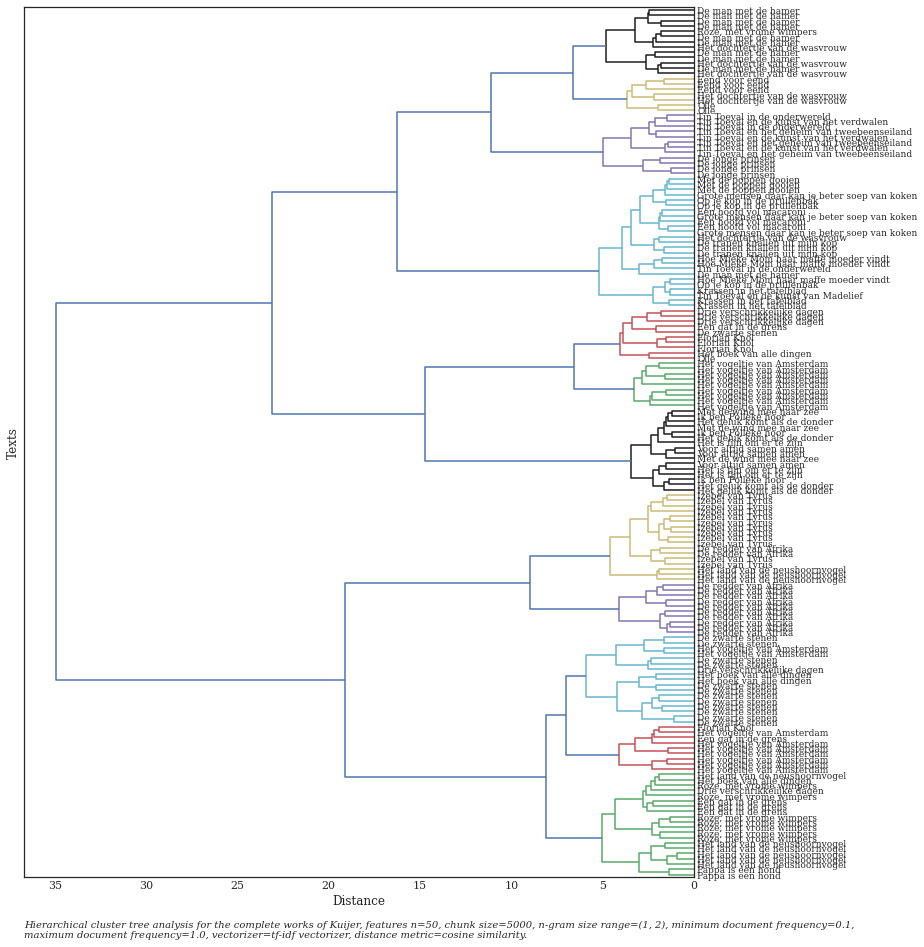

In [5575]:
%matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from textwrap import wrap

import seaborn as sns

caption_no_chunks = f'Hierarchical cluster tree analysis for the complete works of {", ".join(author_sub_corpus_list)}, features n={max_features}, n-gram size range={ngram_range}, minimum document frequency={min_df}, \nmaximum document frequency={max_df}, vectorizer={vectorizer_choice}, distance metric={distance_metric}.'
caption_chunks = f'Hierarchical cluster tree analysis for the complete works of {", ".join(author_sub_corpus_list)}, features n={max_features}, chunk size={divlim}, n-gram size range={ngram_range}, minimum document frequency={min_df}, \nmaximum document frequency={max_df}, vectorizer={vectorizer_choice}, distance metric={distance_metric}.'

%pylab inline
pylab.rcParams['figure.figsize']=(12,16)
sns.set()
plt.style.use('seaborn-white')

matplotlib.rc('font', family='serif')
    
# Make the Dendrogram
dendrogram(linkage_matrix, labels=title_list, orientation="left", leaf_font_size=9, color_threshold=6)

# Add x and y axis labels
plt.xlabel("Distance")
plt.ylabel("Texts")
plt.xticks(rotation=0)

if not break_apart:
    plt.title(caption_no_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
    fname=f'gfx/dendro_{author_sub_corpus_list}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}.pdf'
    plt.savefig(fname, bbox_inches="tight")

else:
    plt.title((caption_chunks), y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
    fname=f'gfx/dendro_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}.pdf'
    plt.savefig(fname, bbox_inches="tight")

#### Select parameter (stored as meta-data) for further investigation

In [5576]:
correl_widget = widgets.Select(
    options=['author', 'publication period', 'age of the author', 'intended reader'],
    value='intended reader',
    description='Correlate:',
    disabled=False
)
display(correl_widget)

Select(description='Correlate:', index=3, options=('author', 'publication period', 'age of the author', 'inten…

In [5577]:
# create dictionaries for color selection

sorted_unique_author_list = sorted(set(author_list))
sorted_unique_age_list = sorted(set(age_list))
sorted_unique_period_list = sorted(set(period_list))
sorted_unique_reader_list = sorted(set(reader_list))

colors = ['cornflowerblue','palegreen', 'gold','lightcoral', 'orange', 'orchid', 'olivedrab', 'maroon', 'crimson', 'darkcyan', 'chocolate']

color_dict_author = dict(zip(sorted_unique_author_list, colors))
color_dict_age_author = dict(zip(sorted_unique_age_list, colors))
color_dict_period = dict(zip(sorted_unique_period_list, colors))
color_dict_intended_reader = dict(zip(sorted_unique_reader_list, colors))

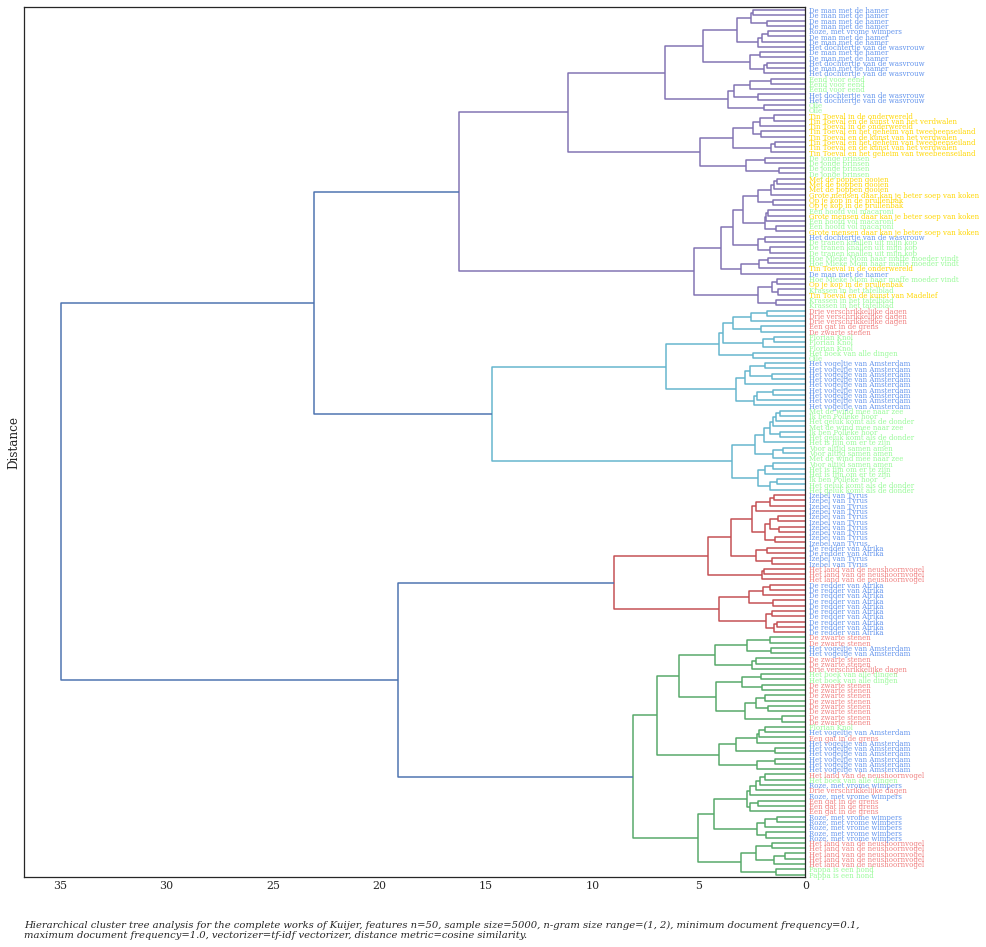

In [5578]:
#%pylab inline
plt.style.use('seaborn-white')
pylab.rcParams['figure.figsize']=(14, 16)
matplotlib.rc('font', family='serif')

dendrogram(linkage_matrix, labels=title_list, leaf_font_size=7,color_threshold=17, orientation="left")
plt.title("Hierarchical Cluster Analysis")
plt.ylabel("Distance")
#plt.xticks(rotation=60)
caption_dendro_chunks = f'Hierarchical cluster tree analysis for the complete works of {", ".join(author_sub_corpus_list)}, features n={max_features}, sample size={divlim}, n-gram size range={ngram_range}, minimum document frequency={min_df}, \nmaximum document frequency={max_df}, vectorizer={vectorizer_choice}, distance metric={distance_metric}.'


# Return information about the tick labels
plt_info = plt.gca()
tick_labels = plt_info.get_ymajorticklabels()

if correl_widget.value == 'author':
    
    # iterate through each tick label and assign color
    for tick_label in tick_labels:
        # get the publication period from the title to publication dictionary
        author_name = title_author[tick_label.get_text()]
        # get the color from the dictionary
        color = color_dict_author[author_name]
        # set the color
        tick_label.set_color(color)
    
    # show the plot
    plt.show()

if correl_widget.value == 'publication period':
    
    # iterate through each tick label and assign color
    for tick_label in tick_labels:
        # get the publication period from the title to publication dictionary
        period = title_period[tick_label.get_text()]
        # get the color from the dictionary
        color = color_dict_period[period]
        # set the color
        tick_label.set_color(color)
    fname=f'gfx/dendro_color_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
    plt.savefig(fname, bbox_inches="tight")
    
    # show the plot
    plt.show()

elif correl_widget.value == 'age of the author':
    
    for tick_label in tick_labels:
        age_author = title_age[tick_label.get_text()]
        color = color_dict_age_author[age_author]
        tick_label.set_color(color)
    
    plt.show()
    
elif correl_widget.value == 'intended reader':
    
    for tick_label in tick_labels:
        intended_reader = title_reader[tick_label.get_text()]
        color = color_dict_intended_reader[intended_reader]
        tick_label.set_color(color)
    fname=f'gfx/dendro_color_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
    plt.title(caption_dendro_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
    plt.savefig(fname, bbox_inches="tight")
    
    plt.show()

### Principal Component Analysis

A good intro to PCAs can be found here: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

In [5579]:
from sklearn.decomposition import PCA

In [5580]:
# create the PCA object
pca = PCA(n_components = 2)

# analyze the dataset
my_pca = pca.fit(similarity).transform(similarity)

In [5581]:
# the input here will be the information you want to use to color the graph.
def info_for_graph(input_list):
    # this will return the unique values. E.g. [a, a, a, b, b] becomes {a, b}
    
    unique_values = set(input_list)
    
    # create a list of numerical label and a dictionary to populate a list
    unique_labels = [i for i in range(0, len(unique_values))]
    unique_dictionary = dict(zip(unique_values, unique_labels))
    
    # make class list
    class_list = []
    for item in input_list:
        class_list.append(unique_dictionary[item])
    
    return unique_labels, np.array(class_list), unique_values

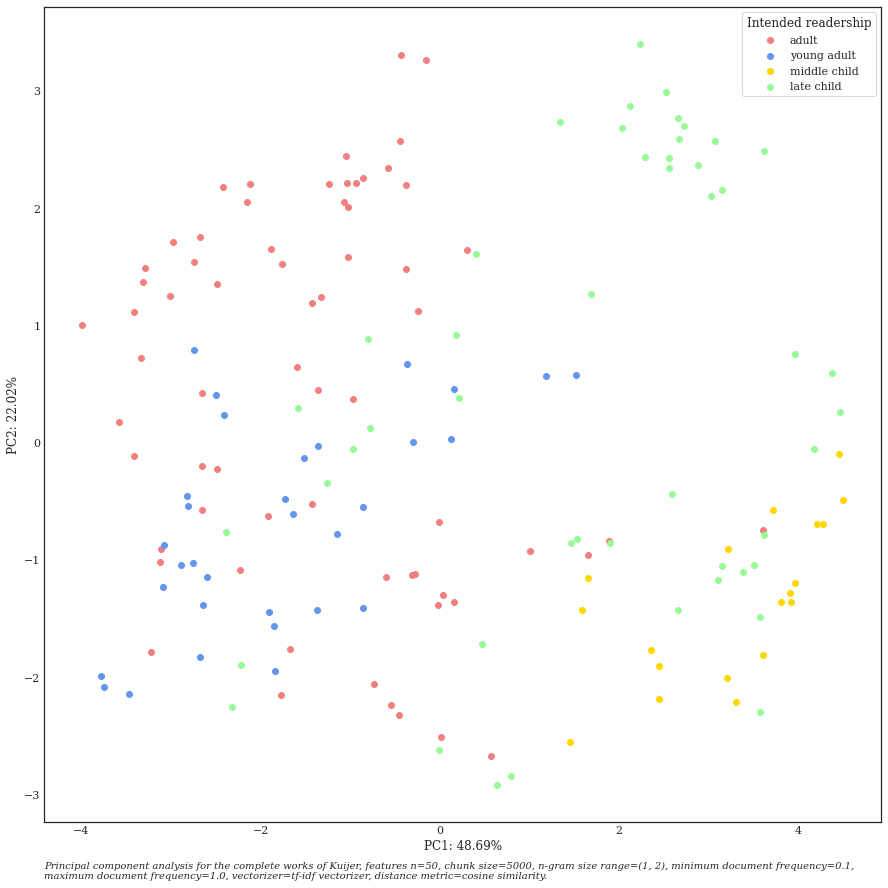

In [5582]:
pylab.rcParams['figure.figsize']=(15,15)

# captions
caption_scatter_no_chunks = f'Principal component analysis for the complete works of {", ".join(author_sub_corpus_list)}, features n={max_features}, n-gram size range={ngram_range}, minimum document frequency={min_df}, \nmaximum document frequency={max_df}, vectorizer={vectorizer_choice}, distance metric={distance_metric}.'
caption_scatter_chunks = f'Principal component analysis for the complete works of {", ".join(author_sub_corpus_list)}, features n={max_features}, chunk size={divlim}, n-gram size range={ngram_range}, minimum document frequency={min_df}, \nmaximum document frequency={max_df}, vectorizer={vectorizer_choice}, distance metric={distance_metric}.'

if correl_widget.value == 'author':
    unique_labels, info_labels, unique_authors = info_for_graph(author_list)
    
    # make a color list, the same length as unique labels
    colors = ["lightcoral", "cornflowerblue", "gold", "palegreen", "orange", "orchid", "olivedrab", "maroon"]
        
    # make the figure
    plt.figure()

    # plot the points using color information.
    # this code is partially adapted from brandonrose.org/clustering
    for color, each_class, label in zip(colors, unique_labels, unique_authors):
        plt.scatter(my_pca[info_labels == each_class, 0],
                    my_pca[info_labels == each_class, 1],
                    label = label, color = color)
    
    # title and labeling of axes
    plt.title("Principal Component Analysis")
    plt.xlabel("PC1: " + "{0:.2f}".format(pca.explained_variance_ratio_[0] * 100)+"%")
    plt.ylabel("PC2: " + "{0:.2f}".format(pca.explained_variance_ratio_[1] * 100)+"%")
    
    # provide legend and show graph
    plt.legend(title="Author", frameon=True, fancybox=True)
    
    if not break_apart:
        plt.title(caption_scatter_no_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")

    else:
        plt.title(caption_scatter_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")
    
    plt.show()

elif correl_widget.value == 'publication period':
    unique_labels, info_labels, unique_periods = info_for_graph(period_list)
    # make a color list, the same length as unique labels
    colors = ["lightcoral", "cornflowerblue", "gold", "palegreen", "orange", "orchid", "olivedrab", "maroon"]
    
    # make the figure
    plt.figure()

    # plot the points using color information.
    # this code is partially adapted from brandonrose.org/clustering
    for color, each_class, label in zip(colors, unique_labels, unique_periods):
        plt.scatter(my_pca[info_labels == each_class, 0],
                    my_pca[info_labels == each_class, 1],
                    label = label, color = color)
    
    # title and labeling of axes
    plt.title("Principal Component Analysis")
    plt.xlabel("PC1: " + "{0:.2f}".format(pca.explained_variance_ratio_[0] * 100)+"%")
    plt.ylabel("PC2: " + "{0:.2f}".format(pca.explained_variance_ratio_[1] * 100)+"%")
    
    # provide legend, save and show graph
    plt.legend(title="Publication period", frameon=True, fancybox=True)
    
    if not break_apart:
        plt.title(caption_scatter_no_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")

    else:
        plt.title(caption_scatter_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")
        
    plt.show()

elif correl_widget.value == 'age of the author':
    unique_labels, info_labels, unique_author_ages = info_for_graph(age_list)
    # make a color list, the same length as unique labels
    colors = ["lightcoral", "cornflowerblue", "gold", "palegreen", "orange"]
    
    # make the figure
    plt.figure()

    # plot the points using color information.
    # this code is partially adapted from brandonrose.org/clustering
    for color, each_class, label in zip(colors, unique_labels, unique_author_ages):
        plt.scatter(my_pca[info_labels == each_class, 0],
                    my_pca[info_labels == each_class, 1],
                    label = label, color = color)
    
    # title and labeling of axes
    plt.title("Principal Component Analysis")
    plt.xlabel("PC1: " + "{0:.2f}".format(pca.explained_variance_ratio_[0] * 100)+"%")
    plt.ylabel("PC2: " + "{0:.2f}".format(pca.explained_variance_ratio_[1] * 100)+"%")
    
    # provide legend, save and show graph
    plt.legend(title="Age of the author", frameon=True, fancybox=True)
    
    if not break_apart:
        plt.title(caption_scatter_no_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")

    else:
        plt.title(caption_scatter_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")
    
    plt.show()
    
elif correl_widget.value == 'intended reader':
    unique_labels, info_labels, unique_intended_readers = info_for_graph(reader_list)
    # make a color list, the same length as unique labels
    colors = ["lightcoral", "cornflowerblue", "gold", "palegreen", "orange", "orchid", "olivedrab", "maroon"]
    # make the figure
    plt.figure()

    # plot the points using color information.
    # this code is partially adapted from brandonrose.org/clustering
    for color, each_class, label in zip(colors, unique_labels, unique_intended_readers):
        plt.scatter(my_pca[info_labels == each_class, 0],
                    my_pca[info_labels == each_class, 1],
                    label = label, color = color)
    
    # title and labeling of axes
    plt.title("Principal Component Analysis")
    plt.xlabel("PC1: " + "{0:.2f}".format(pca.explained_variance_ratio_[0] * 100)+"%")
    plt.ylabel("PC2: " + "{0:.2f}".format(pca.explained_variance_ratio_[1] * 100)+"%")
    
    # provide legend, save and show graph
    plt.legend(title="Intended readership", frameon=True, fancybox=True)
    
    if not break_apart:
        plt.title(caption_scatter_no_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")

    else:
        plt.title(caption_scatter_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
        fname=f'gfx/scatter_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
        plt.savefig(fname, bbox_inches="tight")
    
    plt.show()

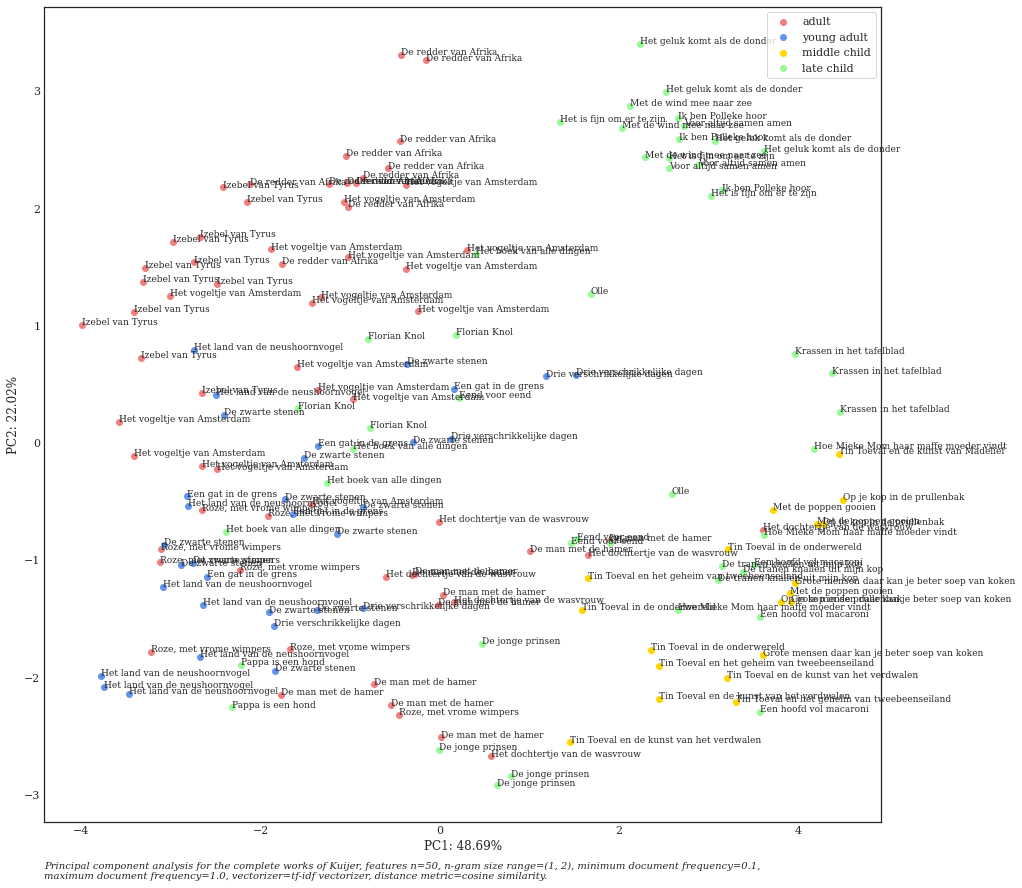

In [5583]:
unique_labels, info_labels, unique_periods = info_for_graph(reader_list)
colors = ["lightcoral", "cornflowerblue", "gold", "palegreen", "orange", "orchid", "olivedrab", "maroon"]
caption_scatter_chunks = f'Principal component analysis for the complete works of {", ".join(author_sub_corpus_list)}, features n={max_features}, n-gram size range={ngram_range}, minimum document frequency={min_df}, \nmaximum document frequency={max_df}, vectorizer={vectorizer_choice}, distance metric={distance_metric}.'

plt.figure()

for color, each_class, label in zip(colors, unique_labels, unique_intended_readers):
    plt.scatter(my_pca[info_labels == each_class, 0],
               my_pca[info_labels == each_class, 1],
               label = label, color = color)
    
for i, text_label in enumerate(title_list):
    plt.annotate(text_label,  xy = (my_pca[i, 0], my_pca[i, 1]),
                 xytext=(my_pca[i, 0], my_pca[i, 1]), 
                 size=9)
    
plt.title(caption_scatter_chunks, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)

plt.xlabel("PC1: " + "{0:.2f}".format(pca.explained_variance_ratio_[0] * 100)+"%")
plt.ylabel("PC2: " + "{0:.2f}".format(pca.explained_variance_ratio_[1] * 100)+"%")
plt.legend(frameon=True, fancybox=True)
fname=f'gfx/scatter_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}_names.pdf'
plt.savefig(fname)
plt.show()

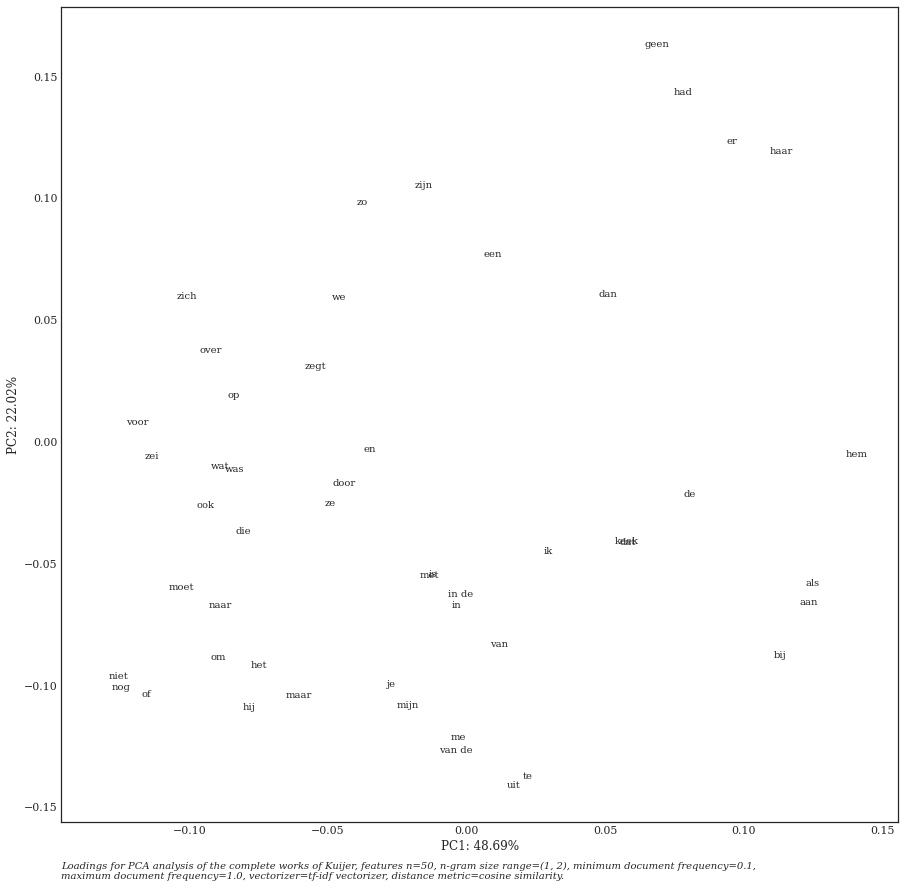

In [5584]:
loadings = pca.components_
loadings_caption = f'Loadings for PCA analysis of the complete works of {", ".join(author_sub_corpus_list)}, features n={max_features}, n-gram size range={ngram_range}, minimum document frequency={min_df}, \nmaximum document frequency={max_df}, vectorizer={vectorizer_choice}, distance metric={distance_metric}.'
# This will plot the locations of the loadings, but make the 
# points completely transparent.
plt.scatter(loadings[0], loadings[1], alpha=0)

# Label and Title
plt.title("Principal Component Loadings")
plt.xlabel("PC1: " + "{0:.2f}".format(pca.explained_variance_ratio_[0] * 100)+"%")
plt.ylabel("PC2: " + "{0:.2f}".format(pca.explained_variance_ratio_[1] * 100)+"%")
plt.title(f'Loadings for PCA analysis of ')

# Iterate through the vocab and plot where it falls on loadings graph
# numpy array the loadings info is held in is in the opposite format of the
# pca information
for i, txt in enumerate(vocab):
    plt.annotate(txt, (loadings[0, i], loadings[1, i]), horizontalalignment='center',
                 verticalalignment='center', size=10)

if not break_apart:
    plt.title(loadings_caption, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
    fname=f'gfx/loadings_{author_sub_corpus_list}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
    plt.savefig(fname, bbox_inches="tight")

else:
    plt.title(loadings_caption, y=-0.075, x=0, fontstyle='italic', fontsize='small', ha='left', wrap=True)
    fname=f'gfx/loadings_{author_sub_corpus_list}_chunksize={divlim}_features={max_features}_mindf={min_df}_maxdf={max_df}_ngram={ngram_range}_metric={distance_metric}_{vectorizer_choice}_correl={correl_widget.value}.pdf'
    plt.savefig(fname, bbox_inches="tight")
    
plt.show()

In [5585]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=4)
pc = pca.fit_transform(similarity)
pc_df = pd.DataFrame(data = pc, columns = ['PC1', 'PC2','PC3','PC4'])
pc_df.head()

,PC1,PC2,PC3,PC4
0,3.918480,-1.357389,0.285129,-0.536588
1,3.957223,-1.197289,-0.334650,-0.140027
2,3.602338,-1.813653,-0.024487,-0.130060
3,1.683742,1.271692,-1.587766,0.934545
4,1.895233,-0.850743,0.331271,-0.750646


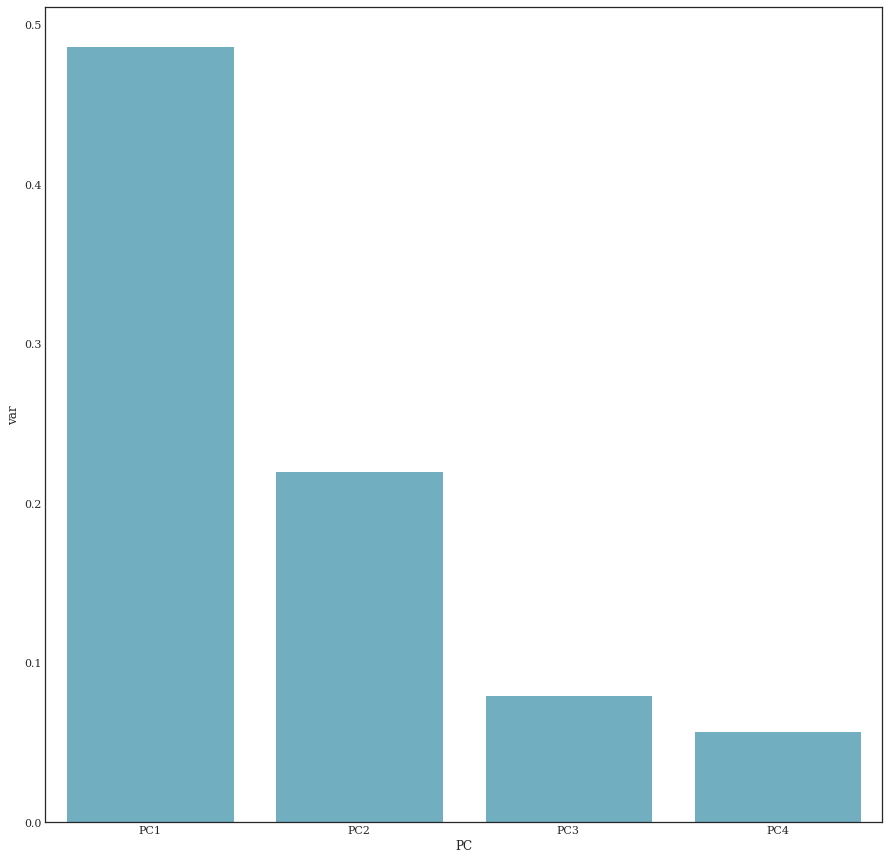

In [5586]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'PC':['PC1','PC2','PC3','PC4']})
sns.barplot(x='PC',y="var", 
           data=df, color="c");